In [107]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import sqlalchemy
import os
import json


In [108]:
conn = psycopg2.connect(
    user="dcat", 
    password="dcat", 
    host="127.0.0.1", 
    port="54320", 
    database="dcat")

In [36]:
conn = psycopg2.connect(
    user="v-oidc-Pau-datacata-8M61CzhFYnWwyGe4RT5T-1573823273", 
    password="A1a-uUUBJHlTN9oyrAQB", 
    host="b27dbvl008.preprod.local", 
    port="5432", 
    database="datacatalog-term")

In [109]:
cur = conn.cursor()

In [135]:
conn.commit()

In [111]:
cur.execute("CREATE EXTENSION IF NOT EXISTS pgcrypto;")

In [112]:
print ( conn.get_dsn_parameters(),"\n")

{'user': 'dcat', 'dbname': 'dcat', 'host': '127.0.0.1', 'port': '54320', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



In [113]:
cur.execute("SELECT version();")
record = cur.fetchone()
print("You are connected to - ", record,"\n")

You are connected to -  ('PostgreSQL 12.0 (Debian 12.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



# Init

In [114]:
#Relationship description/attributes
cur.execute("delete from tbl_edge_desc")
#Relationships/Edges
cur.execute("delete from tbl_edge")
#Node details table
cur.execute("delete from tbl_node")

conn.commit()

# Get data

In [115]:
xls = pd.ExcelFile("../data/testdata.xlsx")
xls.sheet_names

['Formål GML',
 'Formål',
 'Ark1',
 'data-catalog-backend',
 'data-catalog-policies',
 'Category']

# Populate tables

### Relationships

In [116]:
relationships = ["has purpose", "based on purpose", "has attribute", "attribute of","belongs to category", "contains concept"]
for relationship in relationships:
    insert_query = f"insert into tbl_edge_desc (prop) values ('{relationship}')"
    cur.execute(insert_query)
    
conn.commit()

In [117]:
df_links = sqlio.read_sql_query("select * from tbl_edge_desc", conn)
df_links

,id,prop
0,f2cf9df2-0df9-4031-a7ac-5b3584cd9779,has purpose
1,de5b9967-b129-4920-8112-67f773f72d5b,based on purpose
2,b7ff2d8e-f4fd-441d-abdd-9ddc33d834fe,has attribute
3,877a6464-c5ab-47b8-863b-c6b64d815c90,attribute of
4,a4e4c9cd-6ccf-4304-9887-e267ddaea3bc,belongs to category
5,fa316ebd-9a53-4c7a-86e4-7fdb16649da0,contains concept


### Processing activities

In [118]:
sheet=xls.sheet_names[1]
df_formål = pd.read_excel(xls, sheet, encoding='latin1')
df_formål = df_formål[['Forslag til endelig formålskode', 'Formålsbeskrivelse']]
df_formål.columns=['code', 'description']
df_formål['name'] = df_formål['code'].apply(lambda x: x.upper())
df_formål = df_formål.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True)
df_formål.drop(['code'], axis=1, inplace=True)
df_formål['type'] = 'prosessing activity'
df_formål.tail()

,description,name,type
33,Behandle og vurdere rett til uføretrygd som sk...,UFØRETRYGD,prosessing activity
34,Behandle og vurdere rett til ventelønn som ska...,VENTELØNN,prosessing activity
35,Behandle og vurdere rett til ytelser ved yrkes...,YRKESSKADE- OG SYKDOM,prosessing activity
36,Behandle og vurdere rett til ytelser til famil...,YTELSER TIL FAMILIEPLEIER,prosessing activity
37,Not Available -Verdi mangler,NOT AVAILABLE,prosessing activity


In [119]:
for index, row in df_formål.iterrows():
    id = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [120]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
33,5dff4af7-e0dc-4c3a-a4a9-91a1d29f2568,"{'name': 'UFØRETRYGD', 'type': 'prosessing act...",2019-11-20 12:19:02.164634
34,2b2c729f-55b3-4a4f-94dc-c026f3ead951,"{'name': 'VENTELØNN', 'type': 'prosessing acti...",2019-11-20 12:19:02.164634
35,9ebadb16-0c22-4d1a-8735-8fe6f608822d,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pro...",2019-11-20 12:19:02.164634
36,5ff8a031-29e8-4821-bcaa-7a509d47badc,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-11-20 12:19:02.164634
37,a60b0e0f-666e-473e-a6ec-236d2342e9c5,"{'name': 'NOT AVAILABLE', 'type': 'prosessing ...",2019-11-20 12:19:02.164634


### Purpose

In [121]:
df_purpose = df_formål.copy()
df_purpose['type'] = 'purpose'

In [122]:
for i, row in df_purpose.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [123]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
71,7b461733-1314-4114-b3c4-0c9019afe67a,"{'name': 'UFØRETRYGD', 'type': 'purpose', 'des...",2019-11-20 12:19:05.517673
72,50194587-a5bf-469e-aba7-c10b5f69de1c,"{'name': 'VENTELØNN', 'type': 'purpose', 'desc...",2019-11-20 12:19:05.517673
73,27d1cb76-e748-497f-b783-27448fe3b79d,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pur...",2019-11-20 12:19:05.517673
74,3f6e19c0-dd1d-45c4-b1ab-55960a89d685,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-11-20 12:19:05.517673
75,25e879a2-a69b-4168-9b96-613eead323b2,"{'name': 'NOT AVAILABLE', 'type': 'purpose', '...",2019-11-20 12:19:05.517673


### Legal basis

In [124]:
sheet=xls.sheet_names[4]
df_legal_basis = pd.read_excel(xls, sheet, encoding='latin1')
df_legal_basis = df_legal_basis[['legalBasisDescription']].drop_duplicates()
df_legal_basis.columns=['name']
df_legal_basis = df_legal_basis.append({'name': 'NOT AVAILABLE'}, ignore_index=True)
df_legal_basis['type'] = 'legal_basis'
df_legal_basis.head()

,name,type
0,Ftrl. § 11-20,legal_basis
1,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",legal_basis
2,"Kapittel 3, 19, 20 0g 22",legal_basis
3,Ftrl § 3-2 og § 3-3,legal_basis
4,Barnetrygdloven § 9,legal_basis


In [125]:
for i, row in df_legal_basis.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [126]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
232,7b461733-1314-4114-b3c4-0c9019afe67a,"{'name': 'UFØRETRYGD', 'type': 'purpose', 'des...",2019-11-20 12:19:05.517673
233,50194587-a5bf-469e-aba7-c10b5f69de1c,"{'name': 'VENTELØNN', 'type': 'purpose', 'desc...",2019-11-20 12:19:05.517673
234,27d1cb76-e748-497f-b783-27448fe3b79d,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pur...",2019-11-20 12:19:05.517673
235,3f6e19c0-dd1d-45c4-b1ab-55960a89d685,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-11-20 12:19:05.517673
236,25e879a2-a69b-4168-9b96-613eead323b2,"{'name': 'NOT AVAILABLE', 'type': 'purpose', '...",2019-11-20 12:19:05.517673


### Concepts

In [127]:
sheet=xls.sheet_names[3]

df_concepts = pd.read_excel(xls, sheet, encoding='latin1')
df_concepts = df_concepts[['title', 'description']]
df_concepts.columns=['name', 'description']
df_concepts['name'] = df_concepts['name'].apply(lambda x: x.strip().upper())
df_concepts = df_concepts.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True).drop_duplicates()
df_concepts['type'] = 'concept'
df_concepts.head()

,name,description,type
0,SIVILSTAND,En overordnet kategori som beskriver en person...,concept
1,ARBEIDSFORHOLD,"Avtaleforhold hvor den ene part, arbeidstakere...",concept
2,KJØNN,TODO - mangler i begrepskatalogen og i MFNs be...,concept
3,NAVN,I Norge skal alle ha fornavn og ett enkelt ell...,concept
4,FØDSELSDATO,Datoen personen er født.,concept


In [130]:
for i, row in df_concepts.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [131]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
253,f9f27c67-f5c0-44bd-9f4e-1e3089d4e1fc,"{'name': 'BOSTEDSADRESSE I UTLANDET', 'type': ...",2019-11-20 12:21:02.296133
254,1036c65b-d5e5-4d12-b13d-ffed7278fd8b,"{'name': 'FORELDREANSVAR', 'type': 'concept', ...",2019-11-20 12:21:02.296133
255,c3af9ec3-16e5-43a5-a290-597c5a0a6f8d,"{'name': 'FORSTERFORELDRE', 'type': 'concept',...",2019-11-20 12:21:02.296133
256,adf51614-b8a9-4302-9cb4-469d2969ed2b,"{'name': 'FULLMAKT', 'type': 'concept', 'descr...",2019-11-20 12:21:02.296133
257,67e02f0b-d9f2-4b5b-bb34-ccf662339813,"{'name': 'NOT AVAILABLE', 'type': 'concept', '...",2019-11-20 12:21:02.296133


### Categories

In [132]:
sheet=xls.sheet_names[3]
df_categories = pd.read_excel(xls, sheet, encoding='latin1')
df_categories = df_categories[['categories']]
df_categories.columns=['name']
df_categories['name'] = df_categories['name'].apply(lambda x: x.strip().upper())
df_categories = df_categories.append({'name': 'NOT AVAILABLE'}, ignore_index=True).drop_duplicates()
df_categories['type'] = 'category'
df_categories.head()

,name,type
0,PERSONALIA,category
1,ARBEIDSFORHOLD,category
6,KONTAKTOPPLYSNINGER,category
9,FAMILIERELASJONER,category
16,FOLKETRYGD,category


In [136]:
for i, row in df_categories.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

### Nodes

In [137]:
df_nodes = sqlio.read_sql_query("select * from tbl_node", conn)
df_nodes['name'] = df_nodes['prop'].apply(lambda x : x['name'])
df_nodes['type'] = df_nodes['prop'].apply(lambda x : x['type'])
df_nodes.head()

,id,prop,created,name,type
0,3eae9907-c315-4884-9493-18a1ecbce9ae,"{'name': 'Ftrl. § 11-20', 'type': 'legal_basis'}",2019-11-20 12:19:09.509150,Ftrl. § 11-20,legal_basis
1,4e7f41a9-2159-4b62-a1cd-f33de8f96fb6,"{'name': 'Ftrl. §§ 3-16, 3-24, 3-25, 20-8.', '...",2019-11-20 12:19:09.509150,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",legal_basis
2,b1f03d11-b55b-481a-8ba2-8feb50cdb218,"{'name': 'Kapittel 3, 19, 20 0g 22', 'type': '...",2019-11-20 12:19:09.509150,"Kapittel 3, 19, 20 0g 22",legal_basis
3,b1c79f34-862f-4cc8-b317-79e494e1b133,"{'name': 'Ftrl § 3-2 og § 3-3 ', 'type': 'lega...",2019-11-20 12:19:09.509150,Ftrl § 3-2 og § 3-3,legal_basis
4,de212adf-a92b-4ba1-8081-57c464778055,"{'name': 'Barnetrygdloven § 9', 'type': 'legal...",2019-11-20 12:19:09.509150,Barnetrygdloven § 9,legal_basis


### Edges

In [138]:
sheet=xls.sheet_names[3]
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['title', 'categories']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,SIVILSTAND,PERSONALIA
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,KJØNN,PERSONALIA
3,NAVN,PERSONALIA
4,FØDSELSDATO,PERSONALIA


In [139]:
cur.execute("delete from tbl_edge")
conn.commit()

for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'category')), 'id'].item()
    cur.execute(f"insert into tbl_edge values ({source_id},{target_id},array[5],now());")
    
conn.commit()

ProgrammingError: syntax error at or near "fe037f5"
LINE 1: insert into tbl_edge values (3fe037f5-533b-4a65-97e9-8990c3c...
                                      ^


In [27]:
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['categories', 'title']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,PERSONALIA,SIVILSTAND
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,PERSONALIA,KJØNN
3,PERSONALIA,NAVN
4,PERSONALIA,FØDSELSDATO


In [28]:
for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'category')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'concept')), 'id'].item()
    cur.execute(f"insert into tbl_edge values ({source_id},{target_id},array[6],now());")
    
conn.commit()


In [29]:
sql = "select * from tbl_edge"
df = sqlio.read_sql_query(sql, conn)
df.head()

,n1,n2,prop,created
0,238,259,[5],2019-11-19 20:23:44.548669
1,239,260,[5],2019-11-19 20:23:44.548669
2,240,259,[5],2019-11-19 20:23:44.548669
3,241,259,[5],2019-11-19 20:23:44.548669
4,242,259,[5],2019-11-19 20:23:44.548669


In [30]:
sql = """
create or replace function graph_search1(      
  IN i_root int,                       -- The node that the search is based on        
  IN i_depth int  default 99999,       -- the tier to search (the depth limit)      
  IN i_limit int8 default 2000000000,  -- limit the number of records returned for each tier      
  OUT o_path int[],                    -- output: path, an array of IDs      
  OUT o_point1 int,                    -- output: point 1 ID      
  OUT o_point2 int,                    -- output: point 2 ID      
  OUT o_link_prop int2[],              -- output: the connection property between the two current points      
  OUT o_link_prop_all text,            -- output: the connection property from the starting node to the current node      
  OUT o_depth int                      -- output: current depth (tier)      
) returns setof record as 
$$
      
declare      
  sql text;      
begin      
sql := format($_$      
WITH RECURSIVE search_graph(        
  n1,     -- point 1        
  n2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.n1, g.n2] path             -- initial path        
        FROM tbl_edge AS g         
        WHERE         
          n1 = %s                            -- ROOT node=?        
          limit %s                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.n2 path                 -- Add a new point to the path        
        FROM tbl_edge AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.n1 = sg.n2                       -- recursive JOIN condition        
          AND (g.n2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= %s                 -- search depth =?          
          limit %s                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, n1 as o_point1, n2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       
$_$, i_root, i_limit, i_depth, i_limit      
);      
      
return query execute sql;      
      
end;      

$$
 language plpgsql strict;   
"""

cur.execute(sql)

In [31]:
conn.commit()

In [32]:
%%time
sql = "select * from graph_search1(262)"
df = sqlio.read_sql_query(sql, conn)

CPU times: user 1.96 ms, sys: 1.08 ms, total: 3.03 ms
Wall time: 10.4 ms


In [33]:
sql = "select * from graph_search1(262)"
df = sqlio.read_sql_query(sql, conn)

In [34]:
df

,o_path,o_point1,o_point2,o_link_prop,o_link_prop_all,o_depth
0,"[262, 247]",262,247,[6],{6},1
1,"[262, 248]",262,248,[6],{6},1
2,"[262, 249]",262,249,[6],{6},1
3,"[262, 250]",262,250,[6],{6},1
4,"[262, 252]",262,252,[6],{6},1
5,"[262, 253]",262,253,[6],{6},1
6,"[262, 255]",262,255,[6],{6},1
7,"[262, 256]",262,256,[6],{6},1


In [35]:
df_edgelist=df[['o_point1','o_point2','o_link_prop','o_depth']].copy()
df_edgelist.columns=['source','target','id','weight']
df_edgelist['id'] = df_edgelist['id'].apply(lambda x: x[0])
df_edgelist = pd.merge(df_edgelist, df_links, on='id', how='left')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='source', right_on='id')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='target', right_on='id')
df_edgelist = df_edgelist[['prop', 'name_x', 'name_y','id','id_y', 'weight']]
df_edgelist.columns = ['name', 'source', 'target','target_node_id','source_node_id', 'weight']
df_edgelist

,name,source,target,target_node_id,source_node_id,weight
0,contains concept,FAMILIERELASJONER,ADOPSJON,247,262,1
1,contains concept,FAMILIERELASJONER,BARN,248,262,1
2,contains concept,FAMILIERELASJONER,DAGLIG OMSORG,249,262,1
3,contains concept,FAMILIERELASJONER,DELT BOSTED,250,262,1
4,contains concept,FAMILIERELASJONER,FARSKAP,252,262,1
5,contains concept,FAMILIERELASJONER,FLERFØDSEL,253,262,1
6,contains concept,FAMILIERELASJONER,FORELDREANSVAR,255,262,1
7,contains concept,FAMILIERELASJONER,FORSTERFORELDRE,256,262,1


In [39]:
#!pip install nx_altair

In [40]:
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import networkx as nx
import nx_altair as nxa
import numpy as np

G = nx.from_pandas_edgelist(df_edgelist, 'source', 'target', ['name','target_node_id','source_node_id','weight'])
pos = nx.spring_layout(G)

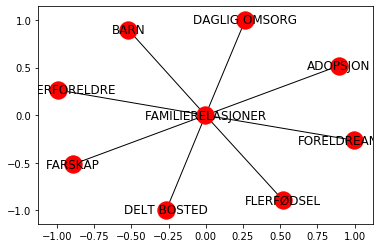

In [43]:
nx.draw_networkx(
    G=G,
    pos=pos
)

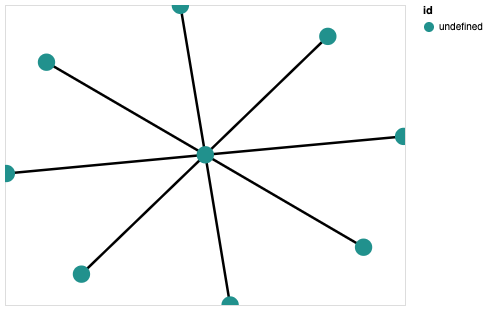

In [44]:
# Compute positions for viz.
pos = nx.spring_layout(G)

viz = nxa.draw_networkx(
    G, pos=pos,
    node_color='id:N',
    cmap='viridis',
    width='weight:N',
    edge_color='black',
    node_tooltip=['weight:N']
)

viz.interactive()